In [4]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 

In [87]:
movies = pd.read_csv('../data/movies.csv')
tags = pd.read_csv('../data/tags.csv')
#Use ratings data to downsample tags data to only movies with ratings 
ratings = pd.read_csv('../data/ratings.csv')
#ratings = ratings.drop_duplicates('movieId')

In [88]:
movies['genres'] = movies['genres'].str.replace('|',' ')
movies.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy
9738,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [89]:
len(movies.movieId.unique())

9742

In [90]:
len(ratings.movieId.unique())

9724

In [91]:
ratings_filter = ratings.groupby('userId').filter(lambda x: len(x) >= 55)
# list the movie titles that survive the filtering
movie_list_rating = ratings_filter.movieId.unique().tolist()

In [93]:
#number movies after filtering
len(ratings_filter.movieId.unique())/len(movies.movieId.unique()) * 100

98.7990145760624

In [94]:
len(ratings_filter.userId.unique())/len(ratings.userId.unique()) * 100


59.67213114754099

In [95]:
movies = movies[movies.movieId.isin(movie_list_rating)]

In [96]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [97]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [98]:
#tags.drop(['timestamp'],1, inplace=True)
#ratings_f.drop(['timestamp'],1, inplace=True)

In [99]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [100]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [101]:
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun,1.525286e+09


In [102]:
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),fantasy magic board game Robin Williams game Adventure Children Fantasy
2,3,Grumpier Old Men (1995),moldy old Comedy Romance


In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(9625, 1675)


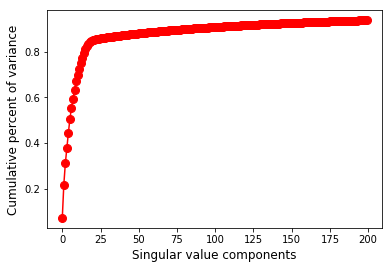

In [104]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [105]:
#number of latent dimensions to keep
n = 200 
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [106]:
# our content latent matrix:
latent_matrix.shape

(9625, 200)

Collaborative Approach

In [107]:
ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [108]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")
ratings_f1.head(10)

,movieId,userId,rating
0,1,1,4.0
1,1,7,4.5
2,1,15,2.5
3,1,17,4.5
4,1,18,3.5
5,1,19,4.0
6,1,21,3.5
7,1,27,3.0
8,1,32,3.0
9,1,33,3.0


In [109]:
#ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [110]:


#ratings_f2.head(3)



In [111]:
len(ratings_f.movieId.unique())

9625

In [112]:
from sklearn.decomposition import TruncatedSVD
#svd = TruncatedSVD(n_components=200)
#latent_matrix_2 = svd.fit_transform(ratings_f2)
#latent_matrix_2_df = pd.DataFrame(
#                             latent_matrix_2,
#                             index=Final.title.tolist())

In [113]:
# plot variance expalined to see what latent dimensions to use
#explained = svd.explained_variance_ratio_.cumsum()
#plt.plot(explained, '.-', ms = 16, color='red')
#plt.xlabel('Singular value components', fontsize= 12)
#plt.ylabel('Cumulative percent of variance', fontsize=12)        
#plt.show()

In [117]:


from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Inception (2010)']).reshape(1, -1)
#a_2 = np.array(latent_matrix_2_df.loc['Inception (2010)']).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
#score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
#hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'cos_similarity': score_1} #, 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('cos_similarity', ascending=False, inplace=True)

similar[1:].head(11)



,cos_similarity
Gattaca (1997),0.627949
Silence (2016),0.595213
Eye in the Sky (2016),0.590004
Shutter Island (2010),0.545177
Black Mirror: White Christmas (2014),0.544547
Donnie Darko (2001),0.531788
Eternal Sunshine of the Spotless Mind (2004),0.531787
Arrival (2016),0.522406
Primal Fear (1996),0.494911
Avatar (2009),0.475683


In [141]:
def get_content_data():
    movies = pd.read_csv('../data/movies.csv')
    
    tags = pd.read_csv('../data/tags.csv')
    ratings = pd.read_csv('../data/ratings.csv')
    

In [142]:
#Data Preprocessing and filtering data
def data_filter():
    
    movies['genres'] = movies['genres'].str.replace('|',' ') #remove horizontal lines from data
    ratings_filter = ratings.groupby('userId').filter(lambda x: len(x) >= 50) #keep only users that review 50 or more movies
    movie_list_rating = ratings_filter.movieId.unique().tolist()
    movies = movies[movies.movieId.isin(movie_list_rating)]
    Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))
    mixed = pd.merge(movies, tags, on='movieId', how='left')
    mixed.fillna("", inplace=True)
    mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
    final_data = pd.merge(movies, mixed, on='movieId', how='left')
    final_data ['metadata'] = Final[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)
        

In [143]:
def get_recommendation_content_filter(movie):
    #'Inception (2010)'
    get_content_data()
    data_filter()
   

    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(Final['metadata'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
    svd = TruncatedSVD(n_components=200)
    latent_matrix = svd.fit_transform(tfidf_df)
    # plot var expalined to see what latent dimensions to use
    n = 200 
    latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=final_data.title.tolist())
    ratings_f1 = pd.merge(movies[['movieId']], ratings_filter, on="movieId", how="right")
    a_1 = np.array(latent_matrix_1_df.loc[movie]).reshape(1, -1)
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    dictDf = {'cos_similarity': score_1} #, 'collaborative': score_2, 'hybrid': hybrid} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index)
    similar.sort_values('cos_similarity', ascending=False, inplace=True)
    

In [21]:
class content_filter:
    def __init__(self):
        pass
    
    def get_content_data(self):
        self.movies = pd.read_csv('../data/movies.csv')
        self.tags = pd.read_csv('../data/tags.csv')
        self.ratings = pd.read_csv('../data/ratings.csv')

    #Data Preprocessing and filtering data
    def data_filter(self):
        self.movies['genres'] = self.movies['genres'].str.replace('|',' ') #remove horizontal lines from data
        self.ratings_filter = self.ratings.groupby('userId').filter(lambda x: len(x) >= 50) #keep only users that review 50 or more self.movies
        movie_list_rating = self.ratings_filter.movieId.unique().tolist()
        self.movies = self.movies[self.movies.movieId.isin(movie_list_rating)]
        Mapping_file = dict(zip(self.movies.title.tolist(), self.movies.movieId.tolist()))
        mixed = pd.merge(self.movies, self.tags, on='movieId', how='left')
        mixed.fillna("", inplace=True)
        mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
        self.final_data = pd.merge(self.movies, mixed, on='movieId', how='left')
        self.final_data ['metadata'] = self.final_data[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)                                                            
                                                                 
    def get_recommendation_content_filter(self, movie):
        #'Inception (2010)'
        self.get_content_data()
        self.data_filter()
                                                                 
        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf.fit_transform(self.final_data['metadata'])
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=self.final_data.index.tolist())
        svd = TruncatedSVD(n_components=200)
        latent_matrix = svd.fit_transform(tfidf_df)
        # plot var expalined to see what latent dimensions to use
        n = 200 
        latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=final_data.title.tolist())
        self.ratings_f1 = pd.merge(self.movies[['movieId']], self.ratings_filter, on="movieId", how="right")
        a_1 = np.array(latent_matrix_1_df.loc[movie]).reshape(1, -1)
        score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
        dictDf = {'cos_similarity': score_1} #, 'collaborative': score_2, 'hybrid': hybrid} 
        similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index)
        similar.sort_values('cos_similarity', ascending=False, inplace=True)
    
                                                                 

In [22]:
cn = content_filter()

In [23]:
cn.get_content_data()
cn.data_filter()
cn.get_recommendation_content_filter('Inception (2010)')

NameError: name 'final_data' is not defined

In [ ]:
#get_recommendation_content_filter('Inception (2010)')